In [1]:
#Importing librariers

import astropy.io.fits as pyfits
from astropy.nddata import CCDData
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as scndi
from scipy.integrate import quad

# Load the data from the fits file
datafile = pyfits.open(r"C:\Users\hp\Downloads\SN2005hc (1).fits")
datafile.info()
data_cube = datafile[1].data
data_cube = data_cube[:-1]

Filename: C:\Users\hp\Downloads\SN2005hc (1).fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1319   ()      
  1  DATA          1 ImageHDU        49   (322, 326, 3682)   float32   
  2                1 ImageHDU        16   (322, 326, 3682)   float32   


In [2]:
#Extracting the info of the header files
flux= datafile[2].data
#print(flux)
datafile[2].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  322                                                  
NAXIS2  =                  326                                                  
NAXIS3  =                 3682                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
HISTORY Image was compressed by CFITSIO using scaled integer quantization:      
HISTORY   q = 4.000000 / quantized level scaling parameter                      
HISTORY 'SUBTRACTIVE_DITHER_1' / Pixel Quantization Algorithm                   
CHECKSUM= 'bpIadmIYbmIabmIY'   / HDU checksum updated 2019-04-24T21:34:47       
DATASUM = '913639248'       

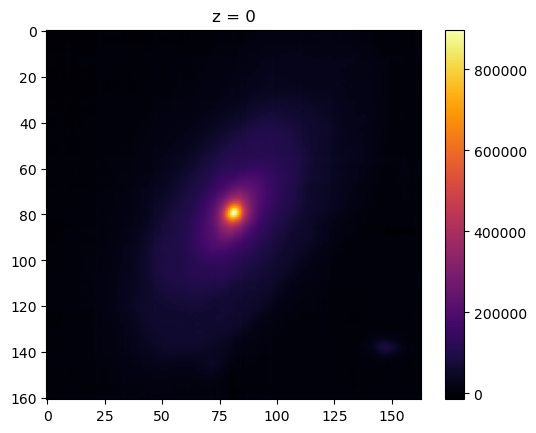

In [3]:
#Plotting the galaxy image

# Collapse the data cube along axis 0
collapsed = np.sum(data_cube, axis=0)
width, height = collapsed.shape
crop_fraction = 0.5 

# Calculate the cropping coordinates
xs = int((1 - crop_fraction) * width / 2)
ys = int((1 - crop_fraction) * height / 2)
xe = int((1 + crop_fraction) * width / 2)
ye = int((1 + crop_fraction) * height / 2)

# Perform cropping
image_cropped1 = collapsed[ys:ye, xs:xe]
plt.imshow(image_cropped1, cmap='inferno')
plt.title("z = 0")
plt.colorbar()
plt.show()
redshift=[0.3,0.8,1.3]
zhigh=0.5


3681


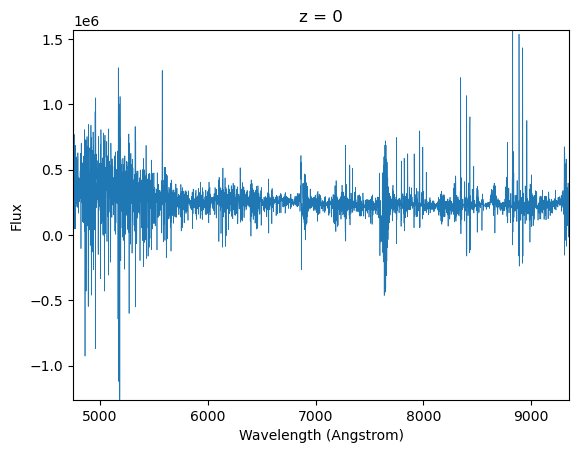

In [4]:
#Plotting the spectral graph of the host galaxy

# Get the wavelength information from the FITS header
crval3 = datafile[1].header['CRVAL3']
cd3_3 = datafile[1].header['CD3_3']
crpix3 = datafile[1].header['CRPIX3']

# Calculate the wavelength axis
wavelengths = (crval3 + (np.arange(data_cube.shape[0]) - (crpix3 - 1)) * cd3_3) * u.Angstrom

# Convert the wavelengths Quantity object to a NumPy array with no units
wavelengths = wavelengths.value
print(len(wavelengths))

# Calculate the collapsed spectrum
collapsed_spectrum = np.nansum(data_cube, axis=(1, 2))
ymin = np.min(collapsed_spectrum)
ymax = np.max(collapsed_spectrum)

# Plot the collapsed spectrum against the wavelength axis
plt.plot(wavelengths, collapsed_spectrum, linewidth=0.5)
plt.title("z = 0")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(ymin, ymax)
plt.show()


In [5]:
#Defining parameters for performing scaling in the host galaxy
from astropy.cosmology import Planck15 as cosmos

Obar = 0.049                 # Baryon Density Parameter
Omat = 0.3                   # Matter Density Parameter
Ok = 0.0                     # Curvature Density Parameter
Orad = 0.0                   # Radiation Density Parameter
Ow = 0.7                     # Dark Energy Density Parameter
w = -1.0                     # DE equation of state parameter p/rho=w
H0 = 70.0                    # km/s/Mpc
Msun = 1.989e30              # kg
Mpc = 3.0857e19              # km
c = 2.9979e5


def Hubble(z, pars=None):
    "Returns the value for the standard Hubble parameter at a redshift z"
    P = {'h': H0 / 100., 'r': Orad, 'm': Omat, 'k': Ok, 'l': Ow, 'w': w}
    if not (pars == None):
        for p in pars:
            P[p] = pars[p]
    return 100 * P['h'] * np.sqrt(P['r'] * (1 + z) ** 4. + P['m'] * (1 + z) ** 3. + P['k'] * (1 + z) ** 2. + P['l'] * (1 + z) ** (3 * (1. + P['w'])))
            
def invHubble(z, pars=None):
    return 1.0 / Hubble(z, pars=pars)
            
def comov_rad(z, pars=None, npoints=10000):
    """Returns the comoving radial distance corresponding to the redshift z in Mpc
    If needed, multiply by h to get the result in units of (h**-1 Mpc)"""
    radius, err = quad(invHubble, 0, z)
    return c * radius

def angular_distance(z, pars=None):
    "Computes the angular diameter distance (Mpc) in a standard LCDM cosmology"
    return comov_rad(z, pars=pars) / (1 + z)
    
#------------------------------------------------------------------------------------------------------------------------------------------------------
#Spatial scalling function
#------------------------------------------------------------------------------------------------------------------------------------------------------
    
## REBBINING 2D SPECTRA
def py_frebin2d(img,Nout,Mout,flux_scale=False):
    """Special case of non-integer magnification for 2D arrays
    from FREBIN of IDL Astrolib. DEPRECATED!!
    """

    N,M = img.shape

    xbox = N/float(Nout)
    ybox = M/float(Mout)

    temp_y = np.zeros([N,Mout],dtype=np.float64)

    for i in range(Mout):
        rstart = i*ybox
        istart = int(rstart)

        rstop = rstart + ybox
        if int(rstop) > M-1:
            istop = M-1
        else:
            istop = int(rstop)

        frac1 = rstart-istart
        frac2 = 1.0 - (rstop-istop)
        if istart == istop:
            temp_y[:,i] = (1.0-frac1-frac2)*img[:,istart]
        else:
            temp_y[:,i] = np.sum(img[:,istart:istop+1],1) - frac1 * img[:,istart] - frac2 * img[:,istop]

    temp_y = temp_y.transpose()
    img_bin = np.zeros([Mout,Nout])

    for i in range(Nout):
        rstart = i*xbox
        istart = int(rstart)

        rstop = rstart + xbox
        if int(rstop) > N-1:
            istop = N-1
        else:
            istop = int(rstop)

        frac1 = rstart-istart
        frac2 = 1.0 - (rstop-istop)

        if istart == istop:
            img_bin[:,i] = (1.0-frac1-frac2)*temp_y[:,istart]
        else:
            img_bin[:,i] = np.sum(temp_y[:,istart:istop+1],1) - frac1 * temp_y[:,istart]- frac2 * temp_y[:,istop]

    if flux_scale:
        return img_bin.transpose()
    else:
        return img_bin.transpose()/(xbox*ybox)
def downscale(image_low,zlow,zhigh,pixscale_low,pixscale_high,upscale=False,fluxscale=True,evo=None,pixscale=True):

    da_in = cosmos.angular_diameter_distance(zlow)
    da_out = cosmos.angular_diameter_distance(zhigh)

    dl_in=da_in*(1+zlow)**2    #cosmos.luminosity_distance(z_low)
    dl_out=da_out*(1+zhigh)**2 #cosmos.luminosity_distance(z_high)

    if evo is not None:
        evo_fact = evo(zlow,zhigh)
    else:
        evo_fact=1.0

    mag_factor = (da_in/da_out)*(pixscale_low/pixscale_high)
    if upscale is True:
        mag_factor=1./mag_factor

    lum_factor = (dl_in/dl_out)**2*(1.+zhigh)/(1.+zlow)
    if fluxscale is False:
        lum_factor=1.0

    if pixscale is False:
        img_out = image_low
    else:
        N,M = image_low.shape
        N_out = int(np.round(N*mag_factor))
        M_out = int(np.round(M*mag_factor))
        img_out = py_frebin2d(image_low,N_out,M_out,flux_scale=True)

    return img_out*lum_factor*evo_fact
#Aplication of spatial 
    
def spatial_scaling(image_low,zlow,zhigh,pixscale_low,pixscale_high,upscale=False,fluxscale=True,evo=None,pixscale=True):
    cube = pyfits.getdata(cube_name)
    cube = cube[:-1]
    cube_downscale = downscale(image_low,zlow,zhigh,pixscale_low,pixscale_high,upscale=False,fluxscale=True,evo=None,pixscale=True)
    
    return cube_downscale

(169, 167)


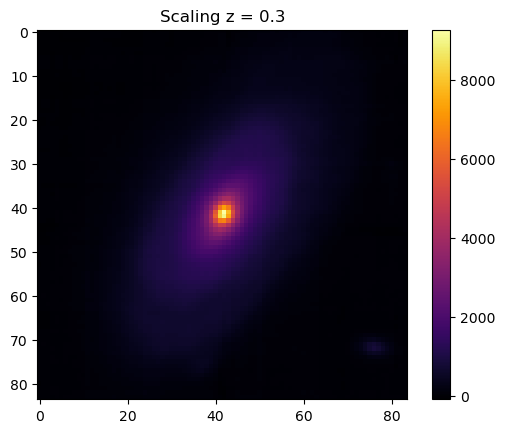

(101, 99)


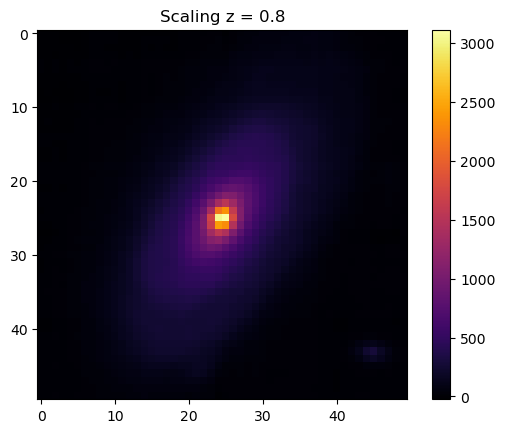

(90, 89)


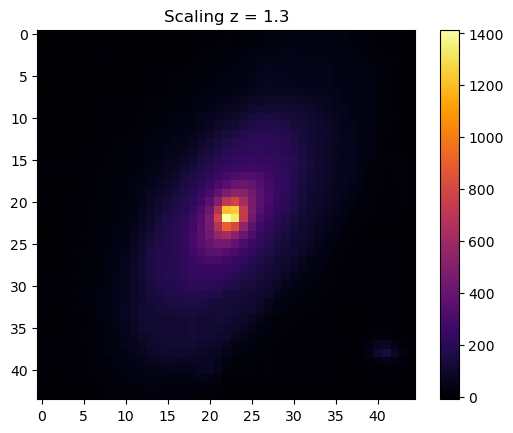

In [6]:
#Constants and other needed things
cube_name =r"C:\Users\hp\Downloads\SN2005hc (1).fits"
cube = pyfits.getdata(cube_name)
cube = cube[:-1]
zlow = 0.017
i= zhigh
pixscale_low = 0.2
pixscale_high = 0.03
image_low = np.sum(cube, axis = 0)
    
    
#Plot of images 
#--------------------------------------------------------------------------
#Scaling alone
#--------------------------------------------------------------------------    
    
for i in redshift:
    cube_downscale = downscale(image_low, zlow, i, pixscale_low, pixscale_high)
    print(cube_downscale.shape)

    width, height = cube_downscale.shape
    crop_fraction = 0.5 

    # Calculate the cropping coordinates
    xs = int((1 - crop_fraction) * width / 2)
    ys = int((1 - crop_fraction) * height / 2)
    xe = int((1 + crop_fraction) * width / 2)
    ye = int((1 + crop_fraction) * height / 2)

    # Perform cropping
    image_cropped = cube_downscale[ys:ye, xs:xe]
    plt.imshow(image_cropped, cmap='inferno')
    plt.title(f"Scaling z = {i}")
    plt.colorbar()
    plt.show()

In [7]:
#Defining parameters for plotting spectral graph of scaling

Obar = 0.049                 # Baryon Density Parameter
Omat = 0.3                   # Matter Density Parameter
Ok = 0.0                     # Curvature Density Parameter
Orad = 0.0                   # Radiation Density Parameter
Ow = 0.7                     # Dark Energy Density Parameter
w = -1.0                     # DE equation of state parameter p/rho=w
H0 = 70.0                    # km/s/Mpc
Msun = 1.989e30              # kg
Mpc = 3.0857e19              # km
c = 2.9979e5

#------------------------------------------------------------------------------------------------------------------------------------------------------
#Definitions for calculations
#------------------------------------------------------------------------------------------------------------------------------------------------------
    
def Hubble(z, pars=None):
    "Returns the value for the standard Hubble parameter at a redshift z"
    P = {'h': H0 / 100., 'r': Orad, 'm': Omat, 'k': Ok, 'l': Ow, 'w': w}
    if not (pars == None):
        for p in pars:
            P[p] = pars[p]
    return 100 * P['h'] * np.sqrt(P['r'] * (1 + z) ** 4. + P['m'] * (1 + z) ** 3. + P['k'] * (1 + z) ** 2. + P['l'] * (1 + z) ** (3 * (1. + P['w'])))
            
def invHubble(z, pars=None):
    return 1.0 / Hubble(z, pars=pars)
            
def comov_rad(z, pars=None, npoints=10000):
    """Returns the comoving radial distance corresponding to the redshift z in Mpc
    If needed, multiply by h to get the result in units of (h**-1 Mpc)"""
    radius, err = quad(invHubble, 0, z)
    return c * radius

def angular_distance(z, pars=None):
    "Computes the angular diameter distance (Mpc) in a standard LCDM cosmology"
    return comov_rad(z, pars=pars) / (1 + z)
    
#------------------------------------------------------------------------------------------------------------------------------------------------------
#Spatial scalling function
#------------------------------------------------------------------------------------------------------------------------------------------------------
    
def ferengi_downscale(cube_low, z_low, z_high, pix_low, pix_high, upscale=False, nofluxscale=True, evo=None):
    da_in = angular_distance(z_low)
    da_out = angular_distance(z_high)
        
    dl_in = da_in * (1 + z_low) ** 2
    dl_out = da_out * (1 + z_high) ** 2

    if evo is not None:
        evo_fact = evo(z_low, z_high)
    else:
        evo_fact = 1.0

    mag_factor = (da_in / da_out) * (pix_low / pix_high)
    if upscale == True:
        mag_factor = 1.0 / mag_factor

    lum_factor = (dl_in / dl_out) ** 2
    if nofluxscale == True:
        lum_factor = 1.0

    cube_out = scndi.zoom(cube_low, (mag_factor, mag_factor, mag_factor), order=1)

    return cube_out * lum_factor * evo_fact
    
  

 #Aplication of spatial 
    
def spatial_scaling(cube_name, zlow, zhigh, pixscale_low, pixscale_high, evo=None):
    cube = pyfits.getdata(cube_name)
    cube = cube[:-1]
    cube_downscale = ferengi_downscale(cube, zlow, zhigh, pixscale_low, pixscale_high, evo=evo)
    
    return cube_downscale
    



In [8]:
#Constants and other needed things
zlow = 0.017
zhigh = i
pixscale_low = 0.2
pixscale_high = 0.03
    
    
#Plot of images 
#--------------------------------------------------------------------------
#Scaling alone
#--------------------------------------------------------------------------    
    
for i in redshift:
    
    downscaled_cube2= spatial_scaling(cube_name, zlow, i, pixscale_low, pixscale_high, evo=None)
    print(downscaled_cube2.shape)
    collapsed_image= np.sum(downscaled_cube2.data, axis= 0)
    
    width, height = collapsed_image.shape
    crop_fraction = 0.5 

    # Calculate the cropping coordinates
    xs = int((1 - crop_fraction) * width / 2)
    ys = int((1 - crop_fraction) * height / 2)
    xe = int((1 + crop_fraction) * width / 2)
    ye = int((1 + crop_fraction) * height / 2)

    # Perform cropping
    #image_cropped = collapsed_image[ys:ye, xs:xe]

    #plt.imshow(image_cropped, cmap='inferno', vmax = 200000)
    #plt.title(f" Scaling z = {i}")
    #plt.colorbar()
    #plt.show()


(1905, 169, 167)
(1130, 100, 99)
(1013, 90, 89)


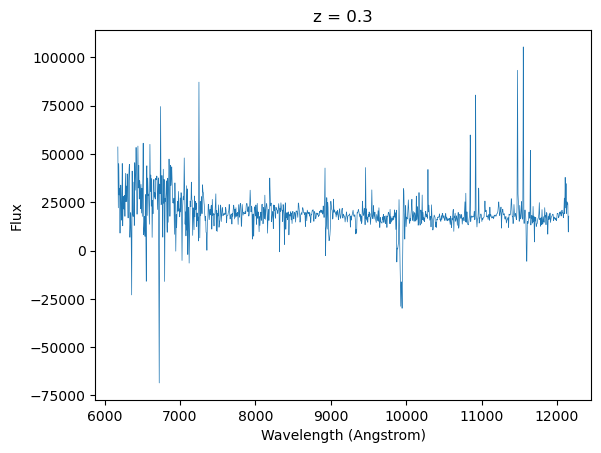

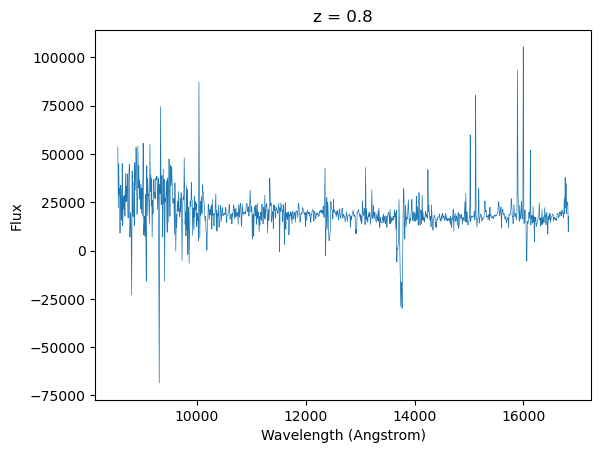

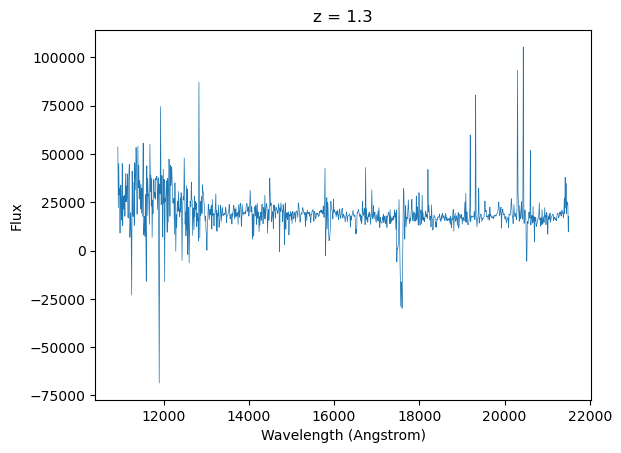

In [9]:
#Plotting the spectral graph
from scipy.interpolate import interp1d

redshifts = [0.3, 0.8, 1.3]

cube_name =r"C:\Users\hp\Downloads\SN2005hc (1).fits"
cube = pyfits.getdata(cube_name)
cube = cube[:-1]
zlow = 0.017
zhigh = i
pixscale_low = 0.2
pixscale_high = 0.03
#image_low = np.sum(cube, axis = 0)

for i in redshifts:
    required_w = wavelengths * (1 + i)
    #downscaled_cube2= spatial_scaling(cube_name, zlow, i, pixscale_low, pixscale_high, evo=None)
    #combined_cube2 = correcteddata (zhigh,downscaled_cube2)


    # Collapse the cube along the spatial dimensions (axis 1 and 2)
    collapsed_spectrumz = np.nansum(downscaled_cube2, axis=(1, 2))

    # Resample the collapsed_spectrum to match the length of wavelengths using linear interpolation
    interpolation_func = interp1d(np.linspace(0, 1, len(collapsed_spectrumz)), collapsed_spectrumz)
    resampled_spectrum = interpolation_func(np.linspace(0, 1, len(wavelengths)))

    plt.plot(required_w, resampled_spectrum, linewidth=0.5)
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title(f"z = {i}")
    plt.show()